# Load the pretrained DDPM model ONLY

Pre-Trained Models
To restore human face images, download this model(from SDEdit) and put it into DDNM/exp/logs/celeba/.

In github readme says:
https://drive.google.com/file/d/1wSoA5fm_d6JBZk4RZ1SzWLMgev4WqH21/view?usp=share_link

In code says:
'https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/celeba_hq.ckpt'

To restore general images, download this model(from guided-diffusion) and put it into DDNM/exp/logs/imagenet/.

wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt


**Target**
Use as basement for other Zero-shot experiments.

**Model**

ImageNet? pretrained, the model defined in `guided_diffusion/models:Model`


See `guided_diffusion/diffusion:Diffusion.sample` for how to load and download weights.

In [ ]:
import sys
sys.path.append("/home/yumeng/workspace/DDNM/MyHack")
import os

gpu_id = "1" 
os.environ['CUDA_VISIBLE_DEVICES'] = f"{gpu_id}"

from pathlib import Path
from matplotlib import pyplot as plt
import cv2

In [51]:
import torch
device = torch.device("cuda")
p_results = Path("/home/yumeng/workspace/DDNM/MyHack/Results")
p_results = p_results.as_posix()

import argparse
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

import numpy as np
def imwrite_m11(path, figure):
    """归一化到了[-1, 1]的图片矩阵保存为图片
    """
    figure = (figure + 1) / 2 * 255
    figure = np.round(figure, 0).astype('uint8')
    cv2.imwrite(path, figure)

def imwrite_01(path, figure):
    """归一化到了[0, 1]的图片矩阵保存为图片
    """
    figure = (figure)* 255
    figure = np.round(figure, 0).astype('uint8')
    cv2.imwrite(path, figure)

def imwrite_r01_rgb(path, figure):
    """图片矩阵保存为图片
    """
    figure = (figure-figure.min())/(figure.max()-figure.min())
    figure=  figure *255
    figure= np.round(figure, 0).astype('uint8')
    plt.imsave(path, figure)

In [ ]:
# /home/yumeng/workspace/DDNM/configs/celeba_hq.yml
celeba_hq = """
data:
    dataset: "CelebA_HQ"
    category: ""
    image_size: 256
    channels: 3
    logit_transform: false
    uniform_dequantization: false
    gaussian_dequantization: false
    random_flip: true
    rescaled: true
    num_workers: 32
    out_of_dist: false

model:
    type: "simple"
    in_channels: 3
    out_ch: 3
    ch: 128
    ch_mult: [1, 1, 2, 2, 4, 4]
    num_res_blocks: 2
    attn_resolutions: [16, ]
    dropout: 0.0
    var_type: fixedsmall
    ema_rate: 0.999
    ema: True
    resamp_with_conv: True

diffusion:
    beta_schedule: linear
    beta_start: 0.0001
    beta_end: 0.02
    num_diffusion_timesteps: 1000

sampling:
    batch_size: 1
    
time_travel:
    T_sampling: 100
    travel_length: 1
    travel_repeat: 1"""

In [ ]:
import yaml
config = yaml.safe_load(celeba_hq)
config = dict2namespace(config)

ckpt = Path("/home/yumeng/workspace/DDNM/exp/logs/celeba/celeba_hq.ckpt").as_posix()

In [ ]:
from models import Model
model=  Model(config)
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device)
model.eval()
model = torch.nn.DataParallel(model)

In [ ]:
# /home/yumeng/workspace/DDNM/guided_diffusion/diffusion.py: get_schedule_jump
def get_schedule_jump(T_sampling, travel_length, travel_repeat):
    jumps = {}
    for j in range(0, T_sampling - travel_length, travel_length):
        jumps[j] = travel_repeat - 1

    t = T_sampling
    ts = []

    while t >= 1:
        t = t-1
        ts.append(t)

        if jumps.get(t, 0) > 0:
            jumps[t] = jumps[t] - 1
            for _ in range(travel_length):
                t = t + 1
                ts.append(t)

    ts.append(-1)

    _check_times(ts, -1, T_sampling)
    return ts

def _check_times(times, t_0, T_sampling):
    # Check end
    assert times[0] > times[1], (times[0], times[1])

    # Check beginning
    assert times[-1] == -1, times[-1]

    # Steplength = 1
    for t_last, t_cur in zip(times[:-1], times[1:]):
        assert abs(t_last - t_cur) == 1, (t_last, t_cur)

    # Value range
    for t in times:
        assert t >= t_0, (t, t_0)
        assert t <= T_sampling, (t, T_sampling)

print("get_schedule_jump(100,1,1) = ")
print(get_schedule_jump(100,1,1))

get_schedule_jump(100,1,1) = 
[99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1]


In [ ]:
import numpy as np
def f1(T,t):
    beta =torch.from_numpy( np.linspace(0,1,T))
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a
try:
    f1(100,0)
except Exception as e:
    print(e)

index_select() received an invalid combination of arguments - got (int, int), but expected one of:
 * (int dim, Tensor index)
      didn't match because some of the arguments have invalid types: (int, !int!)
 * (name dim, Tensor index)
      didn't match because some of the arguments have invalid types: (!int!, !int!)



In [ ]:
import numpy as np


# /home/yumeng/workspace/DDNM/guided_diffusion/diffusion.py:compute_alpha
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    # index_select grammar wrong!
    return a

# /home/yumeng/workspace/DDNM/guided_diffusion/diffusion.py:get_beta_schedule
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):

    if beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

# /home/yumeng/workspace/DDNM/guided_diffusion/diffusion.py:Diffusion.__init__
def compute_beta(config,device):
    betas = get_beta_schedule(
            beta_schedule=config.diffusion.beta_schedule,
            beta_start=config.diffusion.beta_start,
            beta_end=config.diffusion.beta_end,
            num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps,
        )
    betas = torch.from_numpy(betas).float().to(device)
    return betas

def _():
    print("betas = ")
    betas = compute_beta(config,torch.device("cpu"))
    print(betas)
    print()
    print("alphas = ")
    try:
        alphas =[compute_alpha(betas,t) for t in range(len(betas-1))]
        print(alphas)
    except Exception as e:
        print(e)
_()

betas = 
tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04, 2.9920e-04, 3.1912e-04,
        3.3904e-04, 3.5896e-04, 3.7888e-04, 3.9880e-04, 4.1872e-04, 4.3864e-04,
        4.5856e-04, 4.7848e-04, 4.9840e-04, 5.1832e-04, 5.3824e-04, 5.5816e-04,
        5.7808e-04, 5.9800e-04, 6.1792e-04, 6.3784e-04, 6.5776e-04, 6.7768e-04,
        6.9760e-04, 7.1752e-04, 7.3744e-04, 7.5736e-04, 7.7728e-04, 7.9720e-04,
        8.1712e-04, 8.3704e-04, 8.5696e-04, 8.7688e-04, 8.9680e-04, 9.1672e-04,
        9.3664e-04, 9.5656e-04, 9.7648e-04, 9.9640e-04, 1.0163e-03, 1.0362e-03,
        1.0562e-03, 1.0761e-03, 1.0960e-03, 1.1159e-03, 1.1358e-03, 1.1558e-03,
        1.1757e-03, 1.1956e-03, 1.2155e-03, 1.2354e-03, 1.2554e-03, 1.2753e-03,
        1.2952e-03, 1.3151e-03, 1.3350e-03, 1.3550e-03, 1.3749e-03, 1.3948e-03,
        1.4147e-03, 1.4346e-03, 1.4546e-03, 1.4745e-03, 1.4944e-03, 1.5143e-03,
        1.5342e-03, 1.5542e-03,

In [ ]:
def compute_alphas_bar(betas):
    alphas = 1- betas
    alphas_bar= alphas.cumprod(dim=0)
    return alphas_bar

def _():
    print("betas = ")
    betas = compute_beta(config,torch.device("cpu"))
    print(betas)
    print()
    print("alphas_bar = ")
    print(compute_alphas_bar(betas))

_()

betas = 
tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04, 2.9920e-04, 3.1912e-04,
        3.3904e-04, 3.5896e-04, 3.7888e-04, 3.9880e-04, 4.1872e-04, 4.3864e-04,
        4.5856e-04, 4.7848e-04, 4.9840e-04, 5.1832e-04, 5.3824e-04, 5.5816e-04,
        5.7808e-04, 5.9800e-04, 6.1792e-04, 6.3784e-04, 6.5776e-04, 6.7768e-04,
        6.9760e-04, 7.1752e-04, 7.3744e-04, 7.5736e-04, 7.7728e-04, 7.9720e-04,
        8.1712e-04, 8.3704e-04, 8.5696e-04, 8.7688e-04, 8.9680e-04, 9.1672e-04,
        9.3664e-04, 9.5656e-04, 9.7648e-04, 9.9640e-04, 1.0163e-03, 1.0362e-03,
        1.0562e-03, 1.0761e-03, 1.0960e-03, 1.1159e-03, 1.1358e-03, 1.1558e-03,
        1.1757e-03, 1.1956e-03, 1.2155e-03, 1.2354e-03, 1.2554e-03, 1.2753e-03,
        1.2952e-03, 1.3151e-03, 1.3350e-03, 1.3550e-03, 1.3749e-03, 1.3948e-03,
        1.4147e-03, 1.4346e-03, 1.4546e-03, 1.4745e-03, 1.4944e-03, 1.5143e-03,
        1.5342e-03, 1.5542e-03,

In DDPM paper, EQ4:
$$q(x_t|x_0)=\mathcal{N}(x_t;\sqrt{\bar{\alpha}_t}x_0,(1-\bar{\alpha}_t)I),
$$
that is,
$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\mathcal{N}(0,I)
$$

In DDNM paper, EQ12,
$$x_{0|t}= \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \mathcal{Z}_\theta(x_t,t)\sqrt{1-\bar{\alpha}_t})
$$
As a result, in DDNM paper, `et = model(xt, t)` is the $\mathcal{Z}_\theta(x_t,t)$(DDNM) or $\epsilon_\theta(x_t,t)$(DDPM).

In DDPM, the sampling,
$$x_{t-1}:=\frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t)) + \sigma_tz,~z \sim \mathcal{N}(0,I).
$$

In [24]:
import tqdm

# /home/yumeng/workspace/DDNM/guided_diffusion/diffusion.py:simplified_ddnm_plus
def sample(model,betas,device,n=1,path=None):
    """ddpm sampling
    """
    N = n*n# gernerate a grid of images

    # init x_T
    x = torch.randn(
        n*n,
        config.data.channels,
        config.data.image_size,
        config.data.image_size,
        device=device,
    )
    with torch.no_grad():
        T = config.diffusion.num_diffusion_timesteps
        N = x.size(0)
        times = np.arange(T)
        times = times[::-1]
        time_pairs = list(zip(times[:-1], times[1:])) # (t,t-1), t=99,98,...,0
        alphas = 1- betas
        alphas_bar = compute_alphas_bar(betas)
        # reverse diffusion sampling
        xt = x
        for i, j in tqdm.tqdm(time_pairs):
            t = (torch.ones(N) * i).to(x.device)
            next_t = (torch.ones(N) * j).to(x.device)
            at = alphas[i]
            abt = alphas_bar[i]
            bbt = 1-abt
            bt = 1-at
            et = model(xt, t)
            sqrt = torch.sqrt
            # DDPM
            sigma = sqrt(bt)
            eps = torch.randn_like(xt)
            xt = 1/sqrt(at)*(xt- bt/sqrt(bbt)*et) +eps*sigma

    x_samples = xt.detach().cpu().permute(0,2,3,1)
    x_samples = x_samples.numpy()
    img_size = config.data.image_size
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            digit = (digit-digit.min())/(digit.max()-digit.min())
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    p = Path(path)
    path = Path(p.parent,p.stem + "_m11" + p.suffix).as_posix()
    print(path)
    imwrite_r01_rgb(path, figure)
    return x_samples

def _():
    betas = compute_beta(config,device)
    imgs=  sample(model,betas,device,4,Path(p_results,"sample_celebahq.png").as_posix())
    return imgs

imgs = _()

100%|██████████| 999/999 [11:05<00:00,  1.50it/s]


In [25]:
print(imgs.shape)
print(imgs.max(),imgs.min())

(16, 256, 256, 3)
1.1954174 -1.161116


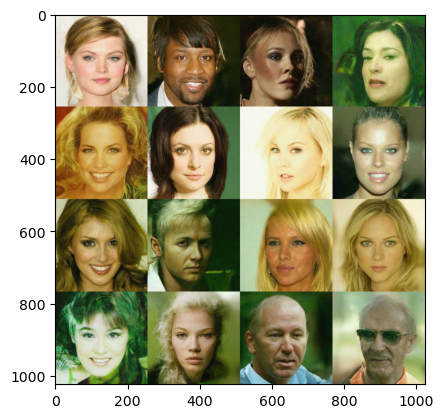

In [52]:
img_size = 256
n = 4
figure = np.zeros((img_size * n, img_size * n, 3))
for i in range(n):
    for j in range(n):
        digit = imgs[i * n + j]
        digit = (digit-digit.min())/(digit.max()-digit.min())
        figure[i * img_size:(i + 1) * img_size,
                j * img_size:(j + 1) * img_size] = digit
imwrite_r01_rgb("/home/yumeng/workspace/DDNM/MyHack/Results/sample_celebahq.png",figure)
plt.imshow(figure)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


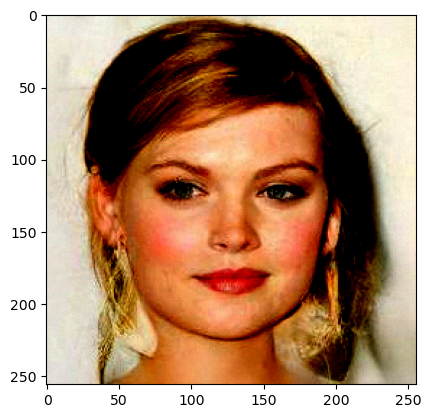

In [34]:
from matplotlib import pyplot as plt
plt.imshow(imgs[0])